# Implement a Siamese network

I will build a basic Siamese Network to find the similarity or dissimilarity between faces. I will use VGGFace as a backbone and contrastive as a loss function.

## Imports

In [1]:
import os
import random
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
import itertools
import cv2
from keras_vggface.vggface import VGGFace

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from keras import layers, applications

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

## Prepare the Dataset

In [3]:
data_dir = '1_face_recognition_dataset/Extracted Faces'

classes = os.listdir(data_dir)

pairs = []
for i, cls in enumerate(classes):
    class_dir = os.path.join(data_dir, cls)
    imgs = os.listdir(class_dir)

    full_imgs = [f'{class_dir}/{img}' for img in imgs]
    pos_pairs = list(itertools.combinations(full_imgs, r=2))
    pos_pairs = [(pair, 1) for pair in pos_pairs]

    neg_classes = np.random.choice(np.delete(np.array(classes), i), 3)
    
    neg_pairs = []
    for i in full_imgs:
        for j in neg_classes:
            neg_class_dir = os.path.join(data_dir, j)
            neg_imgs = os.listdir(neg_class_dir)

            neg_pairs.append(((i, f'{neg_class_dir}/{np.random.choice(neg_imgs)}'), 0))

    pairs.extend(pos_pairs)
    pairs.extend(neg_pairs)

image_pairs, labels = zip(*pairs)


image_pairs = np.array(image_pairs)
labels = np.array(labels)


print("Image pairs shape:", image_pairs.shape)
print("Labels shape:", labels.shape)

Image pairs shape: (50311, 2)
Labels shape: (50311,)


## Custom Data Generator

I will write my own custom generator to extract the images from directories during the training

In [4]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self, image_pairs, labels, batch_size=64):
        self.image_pairs = image_pairs
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_pairs) / self.batch_size))

    def __getitem__(self, idx):
        batch_pairs = self.image_pairs[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Завантажуємо зображення для кожного шляху в парі
        images = []
        for pair in batch_pairs:
            image1 = load_img(pair[0], target_size=(224, 224))
            image2 = load_img(pair[1], target_size=(224, 224))

            image1 = img_to_array(image1) / 255.0
            image2 = img_to_array(image2) / 255.0

            images.append([image1, image2])
        
        images = np.array(images).astype('float32')

        return (images[:,0], images[:,1]), np.array(batch_labels).astype('float32')

## Split data

In [5]:
X_train, X_val, y_train, y_val = train_test_split(image_pairs, labels, test_size=0.2, random_state=42)

batch_size = 32

train_generator = CustomDataGen(X_train, y_train, batch_size=batch_size)
test_generator = CustomDataGen(X_val, y_val, batch_size=batch_size)

In [6]:
iter_train_generator = iter(train_generator)

In [7]:
x, y = next(iter_train_generator)
x[0].shape

(32, 224, 224, 3)

## Build the Model

Let's define some utilities for building our model.


In [8]:
def make_embedding():
    inp = Input(shape=(224,224,3), name='input_image')
    base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    d = base_model(inp)
    return Model(inputs=[inp], outputs=[d], name='embedding')


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [9]:
base_network = make_embedding()

# create the left input and point to the base network
input_a = Input(shape=(224,224,3), name="left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(224,224,3), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 right_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 2048)         23561152    ['left_input[0][0]',             
                                                                  'right_input[0][0]']        

In [11]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

## Train the Model

In [12]:
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer='adam')
history = model.fit(train_generator, epochs=30, validation_data=test_generator)

Epoch 1/30
1258/1258 [==============================] - 963s 756ms/step - loss: 4.7959 - val_loss: 0.1158
Epoch 2/30
1258/1258 [==============================] - 943s 750ms/step - loss: 0.0969 - val_loss: 0.0790
Epoch 3/30
1258/1258 [==============================] - 943s 750ms/step - loss: 0.0648 - val_loss: 0.0661
Epoch 4/30
1258/1258 [==============================] - 944s 750ms/step - loss: 0.0519 - val_loss: 0.0591
Epoch 5/30
1258/1258 [==============================] - 944s 750ms/step - loss: 0.0472 - val_loss: 0.0637
Epoch 6/30
1258/1258 [==============================] - 944s 750ms/step - loss: 0.0501 - val_loss: 0.0769
Epoch 7/30
1258/1258 [==============================] - 943s 750ms/step - loss: 0.0515 - val_loss: 0.0715
Epoch 8/30
1258/1258 [==============================] - 943s 750ms/step - loss: 0.0541 - val_loss: 0.0818
Epoch 9/30
1258/1258 [==============================] - 944s 750ms/step - loss: 0.0521 - val_loss: 0.1038
Epoch 10/30
1258/1258 [=======================

In [14]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [15]:
loss = model.evaluate(train_generator)

1258/1258 [==============================] - 973s 773ms/step - loss: 0.0070


In [190]:
iter_test_generator = iter(test_generator)

In [191]:
batch = next(iter_test_generator)

In [192]:
y_pred_test = model.predict(batch[0])
test_accuracy = compute_accuracy(batch[1], y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, 0, test_accuracy))

Loss = 0.006955393590033054, Train Accuracy = 0 Test Accuracy = 1.0


In [193]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [194]:
batch[0][1][:1].shape

(1, 224, 224, 3)

In [195]:
model.predict([batch[0][0][:1], batch[0][1][:1]])

array([[1.0474662]], dtype=float32)

In [216]:
image1 = load_img('test.png', target_size=(224, 224))
image2 = load_img('5.png', target_size=(224, 224))

image1 = img_to_array(image1) / 255.0
image2 = img_to_array(image2) / 255.0

image1 = np.expand_dims(image1, axis=0)
image2 = np.expand_dims(image2, axis=0)

model.predict([image1, image2])

array([[0.36429673]], dtype=float32)

## Results

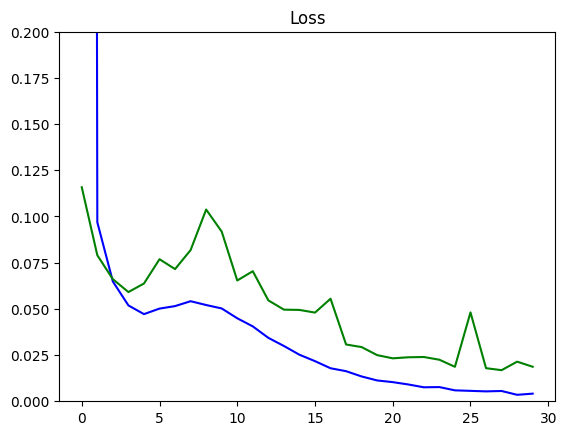

In [197]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [214]:
def show_images_with_title(image1, image2, title):
    """
    Відображає дві картинки разом з заголовком.

    Параметри:
    - image1: numpy.ndarray, перше зображення
    - image2: numpy.ndarray, друге зображення
    - title: str, заголовок
    """
    # Створюємо підграфіки (subplots) з розмірами 1x2
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # Встановлюємо заголовок для всієї фігури
    fig.suptitle(title, fontsize=16)

    # Відображаємо перше зображення
    axes[0].imshow(image1)
    axes[0].axis('off')  # вимикаємо вісі

    # Відображаємо друге зображення
    axes[1].imshow(image2)
    axes[1].axis('off')  # вимикаємо вісі

    # Відображення фігури
    plt.tight_layout()
    plt.show()

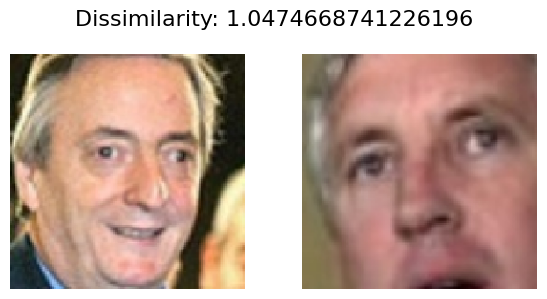

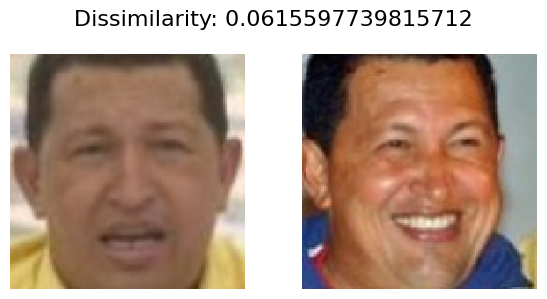

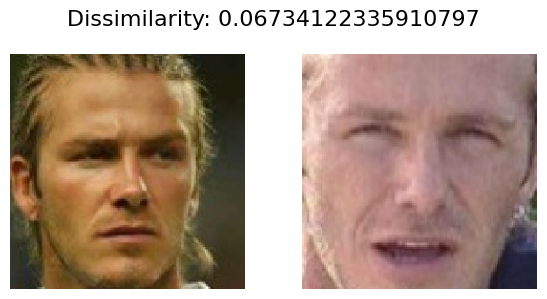

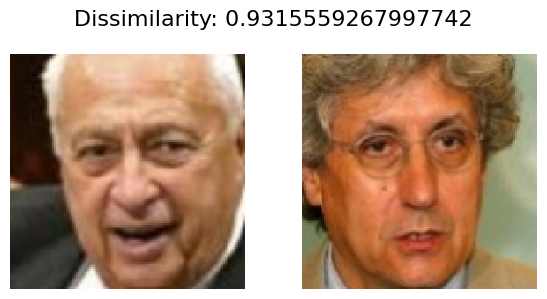

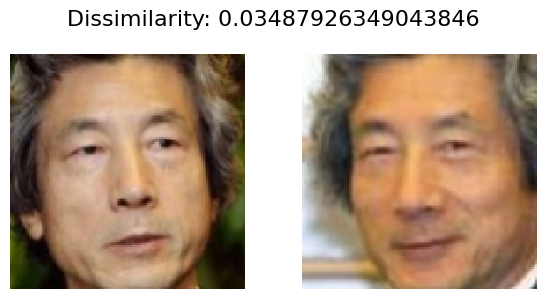

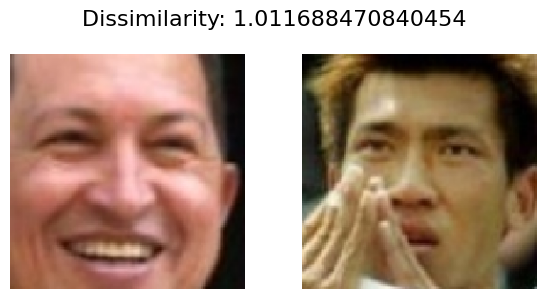

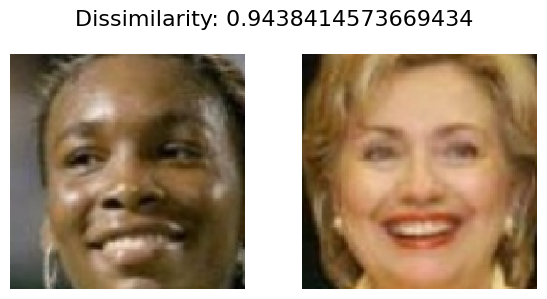

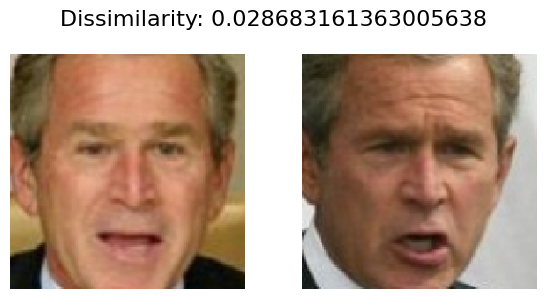

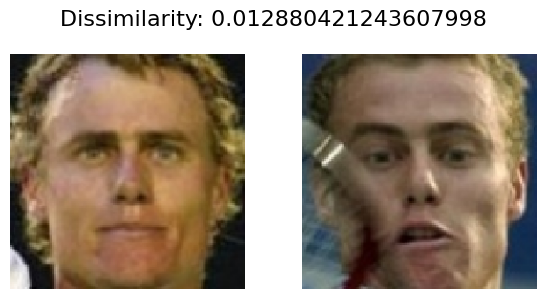

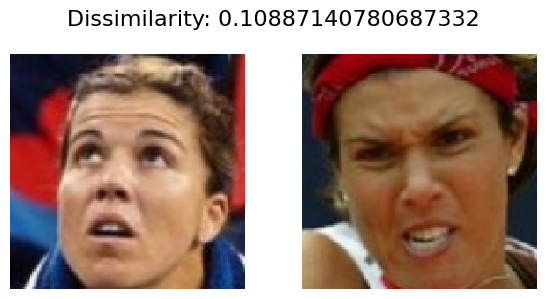

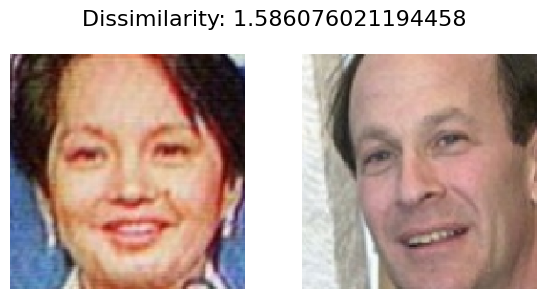

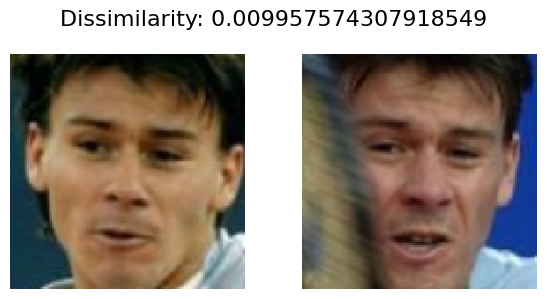

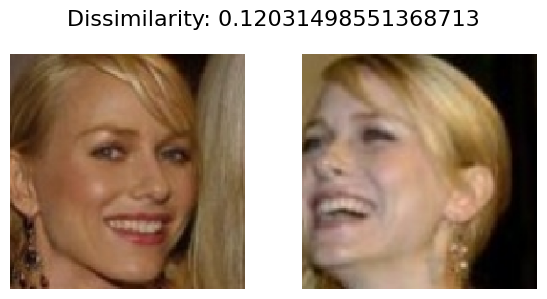

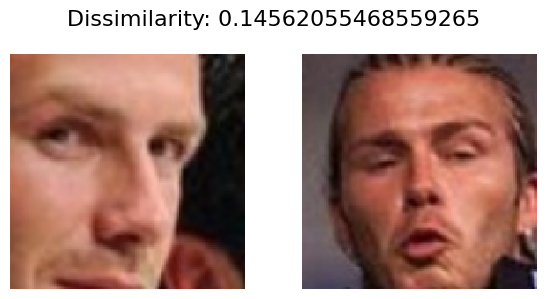

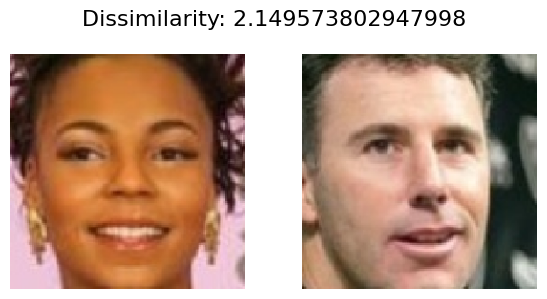

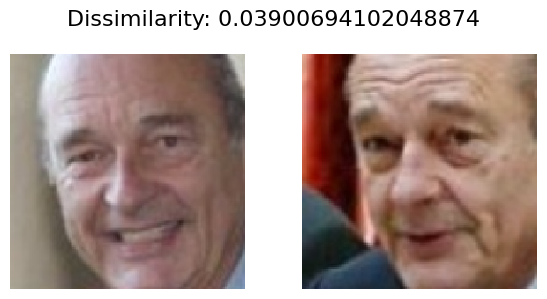

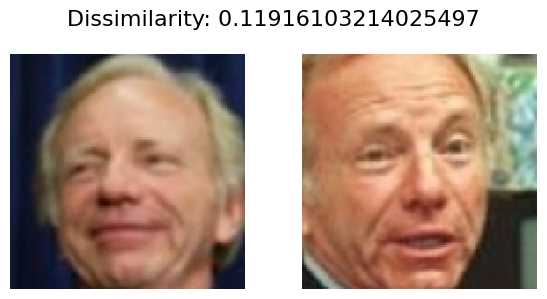

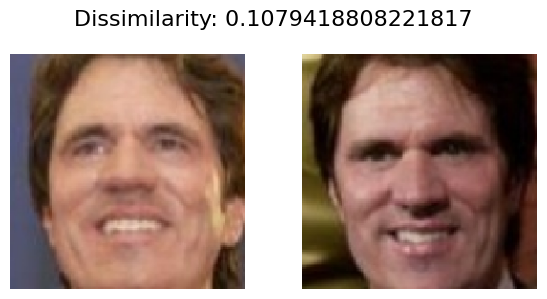

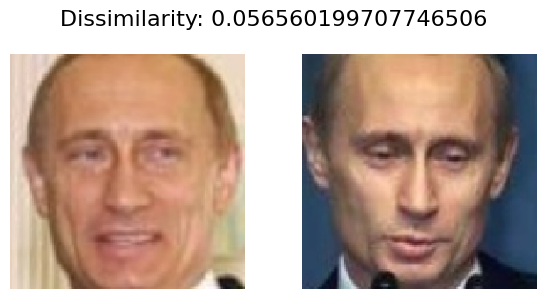

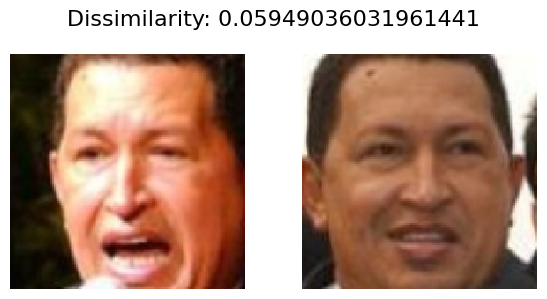

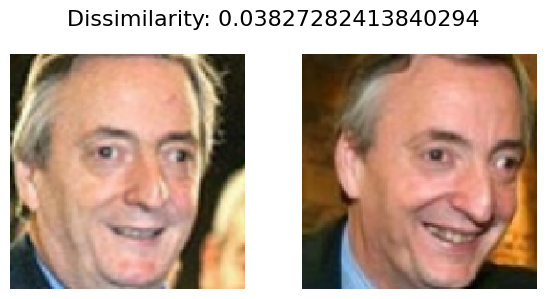

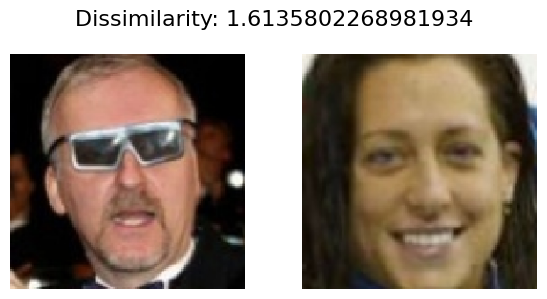

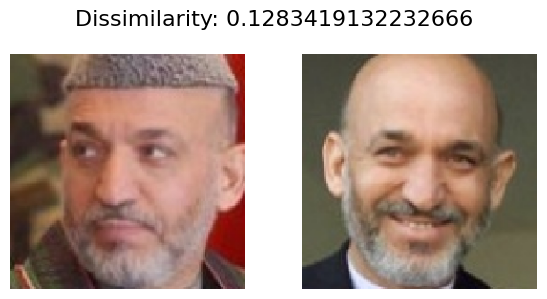

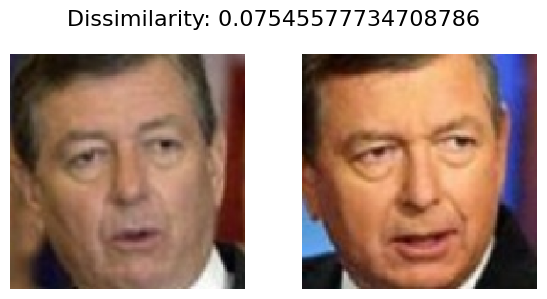

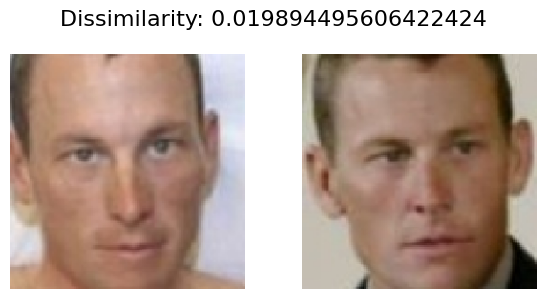

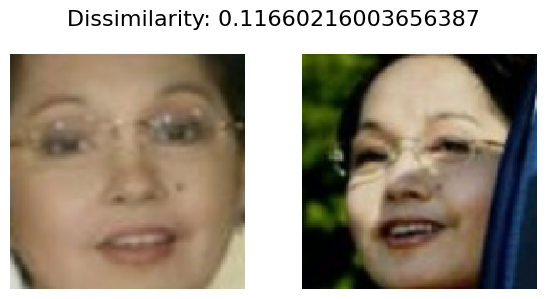

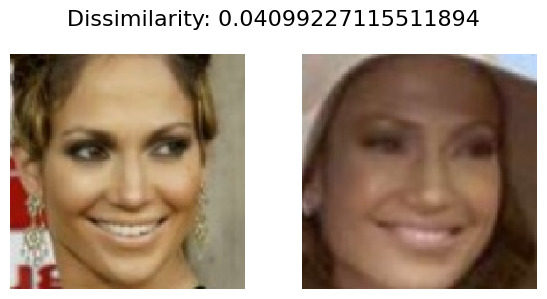

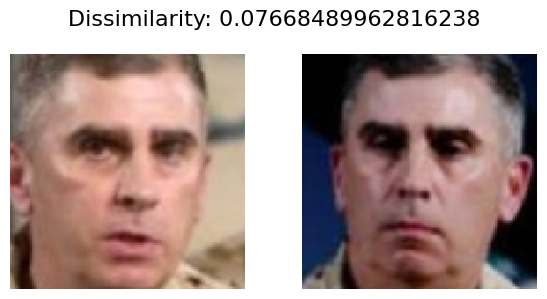

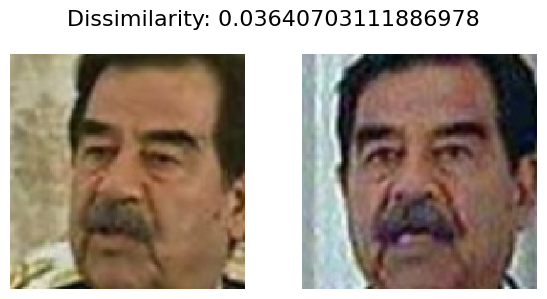

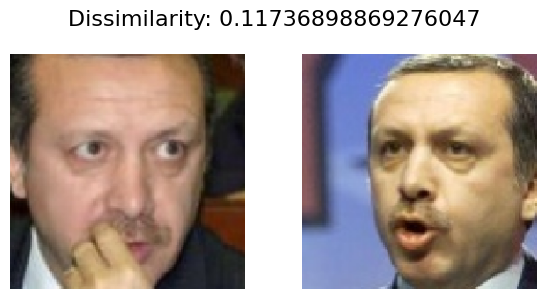

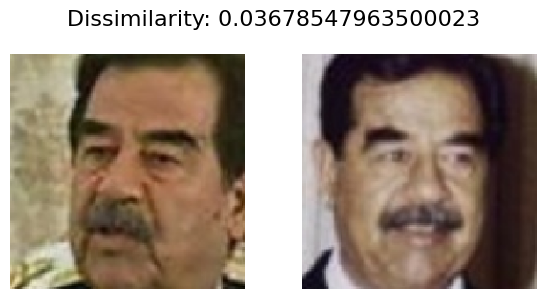

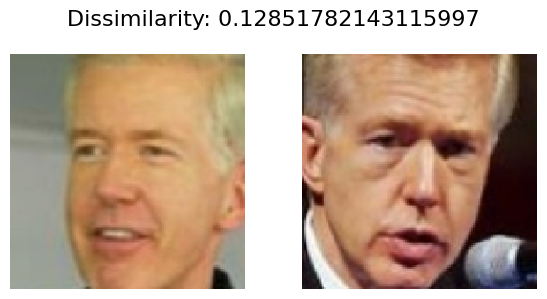

In [215]:
imgs1, imgs2 = batch[0]

for y1, img1, img2 in zip(y_pred_test, imgs1, imgs2):
    show_images_with_title(img1, img2, f'Dissimilarity: {y1[0]}')

## Conclusions

It's not a perfect project, most likely the model has overfitting, and I'll come back to it and try to improve it.